In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from glob import glob
import re
from scipy.stats import wilcoxon, mannwhitneyu

# Set default configuration for all plots
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7, 'font.family': 'sans-serif'})
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.titlesize'] = 7
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
plt.figsize = (2,2)    

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# open the file 
files= glob('data/GO_term_analysis/model_compare/sim_rank_*.tsv')


In [3]:
files

['data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_mixtral_instruct.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_llama2_70b.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gemini_pro.tsv',
 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_35.tsv']

In [13]:
## combine files and sort by semantic similarity score
all_names_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
        
    #rename the column
    df.rename(columns={f'{prefix}_default Name': 'LLM name', f'{prefix}_default Score': 'LLM Score'}, inplace=True)
    df = df.loc[:,['GO', 'Term_Description','LLM name', 'LLM Score','LLM_name_GO_term_sim']]
    df.loc[:,'Model'] = prefix
    all_names_df = pd.concat([all_names_df, df])
    print(all_names_df.shape)
all_names_df.sort_values(by='LLM_name_GO_term_sim', ascending=False, inplace=True)

output_df = pd.concat([all_names_df.head(5), all_names_df.tail(5)])
output_df.to_csv('data/GO_term_analysis/model_compare/all_model_top_bottom_5_GO_terms.tsv', sep='\t', index=False) # Table 1 in the manuscript

(100, 6)
(200, 6)
(300, 6)
(400, 6)
(500, 6)


In [4]:
combined_df = pd.DataFrame()
for file in files:
    df = pd.read_csv(file, sep='\t')
    #if the default Name is 'system of unrelated proteins' remove it from the dataframe

    model_name = '_'.join(file.split('/')[-1].split('.')[0].split('_')[-2:])
    # print(model_name)
    if model_name == 'gpt_35':
        prefix = 'gpt_3.5'
    else:
        prefix = model_name
    df = df[df[f'{prefix}_default Name'] != 'System of unrelated proteins']
    # print(df.shape)
    sem_sim = df.loc[:, ['GO', 'LLM_name_GO_term_sim']]
    # sem_sim = df.loc[:, ['GO', 'true_GO_term_sim_percentile']]
    sem_sim['model'] = model_name
    combined_df = pd.concat([combined_df, sem_sim])
combined_df['model'] = combined_df['model'].map({'gpt_4': 'GPT-4', 'gemini_pro': 'Gemini Pro','gpt_35':'GPT-3.5', 'mixtral_instruct': 'Mixtral Instruct', 'llama2_70b': 'Llama2 70b'})
combined_df.head()

,GO,LLM_name_GO_term_sim,model
0,GO:0014744,0.483668,GPT-4
1,GO:0000338,0.391335,GPT-4
2,GO:0060696,0.479061,GPT-4
3,GO:0019885,0.752696,GPT-4
4,GO:0003166,0.548072,GPT-4


/tmp/ipykernel_666107/1754759280.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)


model:  GPT-4 median:  0.49406657499999995
model:  Gemini Pro median:  0.45542836
model:  GPT-3.5 median:  0.502566115
model:  Mixtral Instruct median:  0.45095879
model:  Llama2 70b median:  0.4035816
GPT-4 vs Llama2 70b: p = 0.0023234923501029865
GPT-3.5 vs Llama2 70b: p = 0.0008411283006340667
Mixtral Instruct vs Llama2 70b: p = 0.01350122051667856


/tmp/ipykernel_666107/1754759280.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')


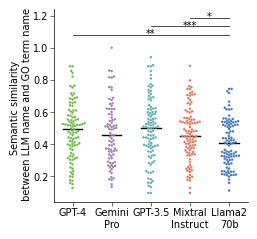

In [5]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
order = ['GPT-4', 'Gemini Pro', 'GPT-3.5','Mixtral Instruct', 'Llama2 70b']
# Perform Mann-Whitney U tests
p_values = {}
for i in range(len(order)):
    for j in range(i+1, len(order)):
        model1 = order[i]
        model2 = order[j]
        data1 = combined_df[combined_df['model'] == model1]['LLM_name_GO_term_sim']
        data2 = combined_df[combined_df['model'] == model2]['LLM_name_GO_term_sim']
        stat, p = mannwhitneyu(data1, data2)
        p_values[(model1, model2)] = p
        
#855C75,#D9AF6B,#AF6458,#736F4C,#526A83,#625377,#68855C,#9C9C5E,#A06177,#8C785D,#467378,#7C7C7C
# sns.violinplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, inner='quartiles', linewidth=0.5, width=0.8,cut=0, palette=['#d88c9a','#f2d0a9','#f1e3d3','#99c1b9','#d2b7e5'], edgecolor='black')

# Add swarm plot
sns.swarmplot(x='model', y='LLM_name_GO_term_sim', data=combined_df, ax=ax, order=order, palette=['#6CBE4C', '#9C80BB', '#65AFAF', '#E07A5F', '#4579BD'], size=1.75, alpha=1)
# add median line 
medians = combined_df.groupby(['model'])['LLM_name_GO_term_sim'].median()
for i in range(len(order)):
    print('model: ', order[i], 'median: ', medians[order[i]])
    ax.plot([i-0.25, i+0.25], [medians[order[i]], medians[order[i]]], lw=1, color='black')


# Determine the maximum y-value
max_y = max(combined_df['LLM_name_GO_term_sim']) + 0.03  # Adjust the 0.03 if needed

# Offset for each bar to prevent overlap
bar_offset = max_y * 0.05  
i = 0
# Loop through your p-values and add bars for each significant pair
for index, ((model1, model2), p_value) in enumerate(p_values.items()):
    if p_value < 0.05:  # Only plot bars for significant differences
        bar_start = order.index(model1)  # x-coordinate for model1
        bar_end = order.index(model2)    # x-coordinate for model2

        # Adjust y-coordinate for the bar to avoid overlap
        y_coord = max_y + bar_offset + (i * bar_offset)

        # Plot the horizontal line for the significance bar
        ax.plot([bar_start, bar_end], [y_coord, y_coord], color='black', lw=0.5)

        # Add text for significance level
        significance_text = "****" if p_value < 0.0001 else "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*"
        ax.text((bar_start + bar_end) / 2, y_coord - 0.01, significance_text, ha='center')
        print(f'{model1} vs {model2}: p = {p_value}')
        i += 1


ax.set_ylabel('Semantic similarity \n between LLM name and GO term name')
ax.set_xlabel('')
ax.set_xticklabels(['GPT-4', 'Gemini\nPro', 'GPT-3.5','Mixtral\nInstruct', 'Llama2\n70b'],rotation=0, ha='center')
sns.despine()
# plt.savefig('figures/model_compare/compare_raw_semantic_similarity_swamp_only.svg', bbox_inches='tight')
plt.show()


# Compare the semantic similarity vs confidence score

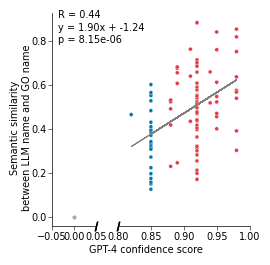

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the data
input_file = 'data/GO_term_analysis/model_compare/sim_rank_LLM_processed_model_compare_100set_gpt_4.tsv'
df = pd.read_csv(input_file, sep='\t')

# Separate the data
zero_df = df[df['gpt_4_default Name'] == 'System of unrelated proteins']
non_zero_df = df[df['gpt_4_default Name'] != 'System of unrelated proteins']


# Create subplots
fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True, figsize=(2.5,2.5), gridspec_kw={'width_ratios': [1, 3]})
fig.subplots_adjust(wspace=0.01)

# First plot for zeros
sns.scatterplot(x = 'gpt_4_default Score', y = 'LLM_name_GO_term_sim',data=zero_df, alpha=1, s=8, ax=ax0, color = '#A5AA99')
ax0.set_xlim(-0.05, 0.05)
ax0.set_xlabel('')
ax0.spines['right'].set_visible(False)
ax0.yaxis.tick_left()
#remove y-axis label
ax0.set_ylabel('')
sns.despine(ax=ax0)

# Define the color palette
palette = {
    'Low Confidence': '#bc6c25',
    'Medium Confidence': '#0077b6',
    'High Confidence': '#e63946'
}

# Second plot for non-zeros
sns.scatterplot(x = 'gpt_4_default Score', y = 'LLM_name_GO_term_sim',data=non_zero_df, hue = 'gpt_4_default Score Bin',palette=palette, alpha=1, s=8, ax=ax1, legend=False)
# plot best fit line
m, b = np.polyfit(non_zero_df['gpt_4_default Score'], non_zero_df['LLM_name_GO_term_sim'], 1)
ax1.plot(non_zero_df['gpt_4_default Score'], m*non_zero_df['gpt_4_default Score'] + b, color='grey', lw=0.75)

ax1.set_xlim(0.80, 1.0)
ax1.set_xlabel('')
ax1.tick_params(labelright=False)  # don't put tick labels at the right
# remove ticks
ax1.yaxis.set_ticks_position('none')
sns.despine(ax=ax1, left=True)


# Add correlation coefficient
r, p = pearsonr(non_zero_df['gpt_4_default Score'], non_zero_df['LLM_name_GO_term_sim'])
fig.text(0.15, 0.9, f'y = {m:.2f}x + {b:.2f}', ha='left', va='center', fontsize=7)
fig.text(0.15, 0.95, f'R = {r:.2f}', ha='left', va='center', fontsize=7)
fig.text(0.15, 0.85, f'p = {p:.2e}', ha='left', va='center', fontsize=7)

# Add common x-label and y-label
fig.text(0.5, 0.01, 'GPT-4 confidence score', ha='center', va='center')
fig.text(0, 0.5, 'Semantic similarity\nbetween LLM name and GO name', ha='center', va='center', rotation='vertical')

# Add the slanted lines to indicate the break at the bottom
d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-d, -1), (d, 1)], markersize=7,
              linestyle="none", color='black', mec='k', mew=1, clip_on=False)
ax0.plot([1, 1], [0, 0], transform=ax0.transAxes, **kwargs)
ax1.plot([0, 0], [0, 0], transform=ax1.transAxes, **kwargs)

# Adjust the layout
plt.tight_layout(w_pad=0.05)
# remove legend, will add it later
plt.legend('') 
# save 
plt.savefig('figures/model_compare/compare_semantic_similarity_vs_raw_confidence_score_scatter_GPT4_split.svg', bbox_inches='tight')
# Show the plot
plt.show()